In [1]:
import numpy as np
import pandas as pd
import pymongo
from pymongo import MongoClient
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn
import itertools
from tensorflow_addons.optimizers import CyclicalLearningRate
import matplotlib as mpl

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder

mpl.style.use('seaborn')

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Import

In [13]:
client = MongoClient()
db = client.ecg_database
collection = db.ecg_signals
df = pd.DataFrame(list(collection.find()))

In [16]:
#df = pd.read_csv("ECG_Rhythm_Lead_I.csv")
labels=df['rhythm_diag']
df.drop(df.iloc[:, 0:8], inplace = True, axis = 1)
labels=labels.replace(['SR','AFIB','OTHER'],[0,1,2])

oversample = SMOTE()
df, labels = oversample.fit_resample(df, labels)
#from imblearn.under_sampling import NearMiss
#undersample = NearMiss(version=1)
#df, labels = undersample.fit_resample(df, labels)

Text(0.5, 1.0, 'Distribution of labels in MIT-BIH Arhythmia dataset')

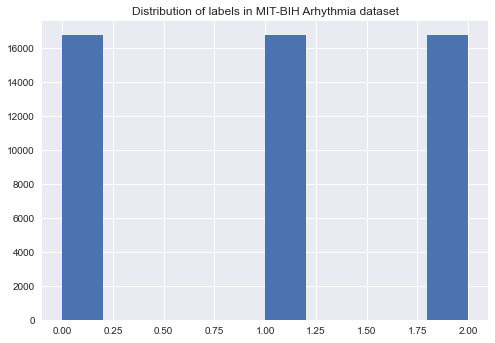

In [4]:
plt.hist(labels)
plt.title("Distribution of labels in MIT-BIH Arhythmia dataset")

Text(0, 0.5, 'Normalized activation')

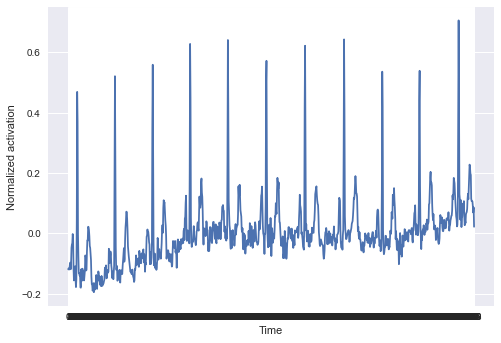

In [5]:
plt.plot(df.iloc[0,:])
plt.xlabel('Time')
plt.ylabel('Normalized activation')

### Building the model

In [17]:
X_train, X_val, y_train, y_val = train_test_split(df, labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test  = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

In [18]:
print("All features size {}".format(df.iloc[:].shape))
print("Train features size {}".format(X_train.shape))
print("Validation features size {}".format(X_val.shape))
print("Test features size {}".format(X_test.shape))

All features size (50346, 1000)
Train features size (40276, 1000)
Validation features size (5035, 1000)
Test features size (5035, 1000)


In [19]:
onehot_encoder = OneHotEncoder(sparse=False)
y_train = onehot_encoder.fit_transform(np.expand_dims(y_train, -1))
y_val = onehot_encoder.fit_transform(np.expand_dims(y_val, -1))
y_test_onehot = onehot_encoder.fit_transform(np.expand_dims(y_test, -1))

In [20]:
def get_resnet_model(categories=3):
  def residual_block(X, kernels, stride):
    out = keras.layers.Conv1D(kernels, stride, padding='same')(X)
    out = keras.layers.ReLU()(out)
    out = keras.layers.Conv1D(kernels, stride, padding='same')(out)
    out = keras.layers.add([X, out])
    out = keras.layers.ReLU()(out)
    out = keras.layers.MaxPool1D(2, 5)(out)
    return out

  kernels = 32
  stride = 5

  inputs = keras.layers.Input([1000,1])
  X = keras.layers.Conv1D(kernels, stride)(inputs)
  X = residual_block(X, kernels, stride)
  X = residual_block(X, kernels, stride)
  X = residual_block(X, kernels, stride)
  X = residual_block(X, kernels, stride)
  X = residual_block(X, kernels, stride)
  X = keras.layers.Flatten()(X)
  X = keras.layers.Dense(32, activation='relu')(X)
  X = keras.layers.Dense(32, activation='relu')(X)
  output = (keras.layers.Dense(3, activation='softmax')(X))

  model = keras.Model(inputs=inputs, outputs=output)
  return model

In [21]:
# Set cyclical learning rate
N = X_train.shape[0]
batch_size = 128
iterations = N/batch_size
step_size= 2 * iterations

lr_schedule = CyclicalLearningRate(1e-6, 1e-3, step_size=step_size, scale_fn=lambda x: tf.pow(0.95,x))
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

### Training

In [ ]:
save_best_weights = ModelCheckpoint(filepath="weights.hdf5", verbose=0, save_best_only=True)

resnet_model = get_resnet_model() 
resnet_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = resnet_model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                           shuffle=True, batch_size=batch_size, epochs=30, callbacks=[save_best_weights])

# Loading best weights and evaluating results

In [22]:
resnet_model = get_resnet_model() 
resnet_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
resnet_model.load_weights('weights.hdf5')
resnet_model.evaluate(X_test, y_test_onehot)

158/158 [==============================] - 3s 11ms/step - loss: 0.2447 - accuracy: 0.9200


[0.24472828209400177, 0.9199602603912354]

Confusion matrix, without normalization


C:\Users\mlade\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  # This is added back by InteractiveShellApp.init_path()


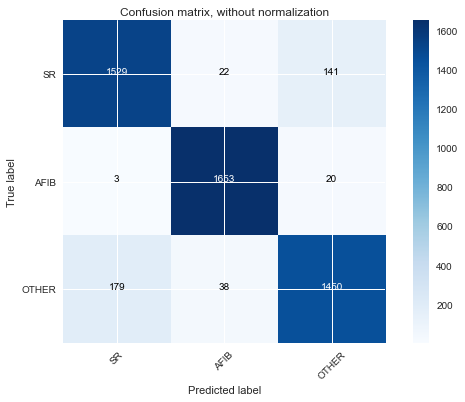

In [23]:
y_pred=[]
predicted = resnet_model.predict(X_test)
for i in range(0,len(predicted)):
  y_pred.append(np.argmax(predicted[i]))

# Compute confusion matrix
cnf_matrix = sklearn.metrics.confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['SR','AFIB','OTHER'],
                      title='Confusion matrix, without normalization')